> Tests for building preprocessing module.

---

# Setup

##### Set Root Dir as CWD

In [1]:
import os

# Navigate to project root (if not already there)
if os.path.split(os.getcwd())[1] != "cs374-project":
    %cd ../

D:\Documents\A_DIGIPEN\PersonalSVN\Fall22SVN\CS374\Project\cs374-project


##### Imports

In [2]:
import numpy as np
import pandas as pd

import spacy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Local
from src.preprocesser import ReviewPreprocessor

# Load

In [3]:
path = "data/yelp/reviews/"

In [4]:
%%time
# Load dev set (10% of total data) as train
train_all = pd.read_pickle(path + "train.xz")

CPU times: total: 30 s
Wall time: 30.8 s


In [5]:
%%time
# Load test set (10% of total data) as test
test_all = pd.read_pickle(path + "test.xz")

CPU times: total: 3.89 s
Wall time: 3.98 s


In [6]:
#num_samples = (10_000, 10_000)

train = train_all.iloc[:] #num_samples[0]]
test = test_all.iloc[:] #num_samples[1]]

In [7]:
train

,text,stars
2903612,I like Wedding Belles for an odd reason. I set...,5
5050964,We had a great stay here. I felt like we got a...,5
1226557,"A unique place for sure, not your standard bre...",3
776083,This will be a short review on service and gri...,4
227582,Great barbershop. Super friendly staff. They a...,5
...,...,...
3578067,I've not personally had the bad experiences th...,4
424533,Dive bar.\nNew ownership has improved the menu...,3
28275,"This place is so addicting, good vegan options...",5
2949771,"What is not to love about Wingfield Park, down...",5


##### Save Target

In [8]:
# Save reviews stars from 0-4
y_train = tf.convert_to_tensor(train["stars"].values - 1)
y_test = tf.convert_to_tensor(test["stars"].values - 1)

# Preprocess

In [9]:
batch_size = 2000
n_processes = 4

maxlen = 200         # Number of words per review to consider
vocab_size = 30_000  # Size of vocabulary

##### Load from raw data

> Preprocess from scratch. Takes a long time!

In [ ]:
%%time
# Configure preprocessor
prep = ReviewPreprocessor(vocab_size, maxlen, alpha_only=False, split_digits=True)

# Preprocess text
X_train_norm = prep.normalize(train["text"], batch_size, n_processes)
X_test_norm = prep.normalize(test["text"], batch_size, n_processes)

# Fit tokenizer
prep.fit_tokenizer(X_train_norm)

# Convert to tensor of padded sequences
X_train = prep.to_tensor(X_train_norm)
X_test = prep.to_tensor(X_test_norm)

In [63]:
%%time
# Save results
pd.Series(X_train_norm).to_pickle(path + "train_prep.xz")
pd.Series(X_test_norm).to_pickle(path + "test_prep.xz")
prep.save_as_pickle("prototypes/preprocessors/prep_v4.pickle")

CPU times: total: 21min 12s
Wall time: 21min 35s


##### Load already preprocessed data

> Load already preprocessed data. Takes a bit.

In [23]:
%%time
# Load preprocessed
X_train_norm = pd.read_pickle(path + "train_prep.xz")
X_test_norm = pd.read_pickle(path + "test_prep.xz")

# Load preprocessor
prep = ReviewPreprocessor.load_from_pickle("prototypes/preprocessors/prep_v4.pickle")

# Convert to tensor of padded sequences
X_train = prep.to_tensor(X_train_norm)
X_test = prep.to_tensor(X_test_norm)

CPU times: total: 3min 45s
Wall time: 3min 52s


##### View Before and After Preprocessing

In [63]:
print_idx = 8
print(test["text"].iloc[print_idx])
print("\n - - - - \n")
print(X_test_norm[print_idx], len(X_test_norm[print_idx]))
print("\n - - - - \n")
print(X_test[print_idx])

Ordered through grub hub, food came half an hour past the maximum delivery window. A simple breakfast order took 90 minutes to get to me, and the potatoes were half raw. Delivery timing may not have been the restaurant's fault, but the undercooked food was.

Delivery fee is actually $3.99, NOT $0 as posted on yelp

 - - - - 

['ordered', 'grub', 'hub', ',', 'food', 'came', 'half', 'hour', 'past', 'maximum', 'delivery', 'window', '.', 'simple', 'breakfast', 'order', 'took', '90', 'e0', 'minutes', ',', 'potatoes', 'half', 'raw', '.', 'delivery', 'timing', 'restaurant', "'", 's', 'fault', ',', 'undercooked', 'food', '.', 'delivery', 'fee', 'actually', '$', '3', 'e0', '.', '99', 'e0', ',', '$', '0', 'e0', 'posted', 'yelp'] 50

 - - - - 

tf.Tensor(
[  28 3360 4189    2    9   34  189  135  388 8113  439  739    1  533
  143   30   73 1525    5   71    2  476  189 1094    1  439 3391   36
    3    8 1326    2 2189    9    1  439 1138  185   21   72    5    1
 1114    5    2   21 1634    5 1

# Model

* Reference https://keras.io/examples/nlp/text_classification_with_transformer/

##### Model Definition

In [25]:
class SentimentClassifier(tf.keras.Model):
    def __init__(self, maxlen, vocab_size, embed_dim, num_heads, ff_dims,
                 reg=1e-3, dropout=0.3):
        super().__init__()
        
        # Token embedding
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,
                                          mask_zero=True, name="t_emb")
        
        # Position embedding
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim,
                                        name="p_emb")
        
        # Self-attention based on token and positional info
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim,
                                             name="attention")
        
        # Feed-forward network with a layer for each number of neurons in ff_dims
        ffn_layers = []
        for dim in ff_dims:
            layer = layers.Dense(dim, activation="relu", 
                                 kernel_regularizer=keras.regularizers.l2(reg))
            ffn_layers.append(layer)
        self.ffn = keras.Sequential(ffn_layers)
        
        # Normalize activation for speed
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        
        # Dropout for regularization
        self.dropout1 = layers.Dropout(dropout)
        self.dropout2 = layers.Dropout(dropout)
        
        # Average 
        self.pool = layers.GlobalAveragePooling1D()
        self.dropout3 = layers.Dropout(dropout)
        self.dense = layers.Dense(20, activation="relu", 
                                  kernel_regularizer=keras.regularizers.l2(reg))
        self.dropout4 = layers.Dropout(dropout)
        
        # 5-star review probability output
        self.stars = layers.Dense(5, activation="softmax")
        
    def call(self, x, training=False, return_att=False):
        # Create boolean mask for attention to ignore padding
        mask = self.token_emb.compute_mask(x)
        mask = mask[:, tf.newaxis, tf.newaxis, :]
        
        # Embed tokens and positional encodings
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        x = x + positions
        
        # Self attention (query = key) -> feed-forward network (w/ add & norm)
        attn_output, attn_scores = self.att(x, x, attention_mask=mask, return_attention_scores=True)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        x = self.layernorm2(out1 + ffn_output)
        
        # Average pooling (along each time step), dropout, one more dense layer
        x = self.pool(x)
        x = self.dropout3(x)
        x = self.dense(x)
        x = self.dropout4(x)
        
        # Softmax for 5-star rating probabilities
        rating_probs = self.stars(x)
        
        if return_att:
            return rating_probs, attn_scores

        return rating_probs

##### Create Model

In [26]:
# Hyperparameters
embed_dim = 32  # Attention output size
num_heads = 2   # Number of attention heads
ff_dims = [32]  # Hidden layer sizes in feed forward network inside transformer
reg = 1.0e-2
dropout = 0.25

# Model
model = SentimentClassifier(maxlen, vocab_size, embed_dim, num_heads, ff_dims, reg, dropout)

In [27]:
model.predict(X_train[:5])

1/1 [==============================] - 0s 245ms/step


array([[0.138145  , 0.21447177, 0.2758931 , 0.2111363 , 0.16035384],
       [0.13431306, 0.21027339, 0.27184397, 0.24156041, 0.14200917],
       [0.12218645, 0.21995899, 0.2885058 , 0.24992295, 0.11942583],
       [0.13935348, 0.20194975, 0.26566684, 0.23138136, 0.16164848],
       [0.11712188, 0.21428674, 0.2827264 , 0.26633888, 0.11952609]],
      dtype=float32)

##### Compile and Run

In [28]:
learning_rate = 1e-3

model.compile(optimizer=keras.optimizers.Adam(learning_rate), 
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.build(X_train.shape)

In [29]:
model.summary()

Model: "sentiment_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 t_emb (Embedding)           multiple                  960000    
                                                                 
 p_emb (Embedding)           multiple                  6400      
                                                                 
 attention (MultiHeadAttenti  multiple                 8416      
 on)                                                             
                                                                 
 sequential_1 (Sequential)   (None, 200, 32)           1056      
                                                                 
 layer_normalization_2 (Laye  multiple                 64        
 rNormalization)                                                 
                                                                 
 layer_normalization_3 (Laye  multiple      

In [30]:
%%time
# Train model
epochs = 10
cp_num = 4

# Early stopping 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)

# Create a callback that saves the model's weights
checkpoint_dir = os.path.dirname(f"model_checkpoints/proto{cp_num}.ckpt")
create_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, monitor="val_loss", verbose=1, save_best_only=True)

history = model.fit(
    X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test),
    callbacks=[early_stopping], verbose=1,
)

Epoch 1/10
174757/174757 [==============================] - 670s 4ms/step - loss: 0.7667 - accuracy: 0.6840 - val_loss: 0.7238 - val_accuracy: 0.6977
Epoch 2/10
174757/174757 [==============================] - 679s 4ms/step - loss: 0.7394 - accuracy: 0.6944 - val_loss: 0.7196 - val_accuracy: 0.6981
Epoch 3/10
174757/174757 [==============================] - 664s 4ms/step - loss: 0.7300 - accuracy: 0.6985 - val_loss: 0.7121 - val_accuracy: 0.7021
Epoch 4/10
174757/174757 [==============================] - 678s 4ms/step - loss: 0.7239 - accuracy: 0.7014 - val_loss: 0.7108 - val_accuracy: 0.7013
Epoch 5/10
174757/174757 [==============================] - 669s 4ms/step - loss: 0.7196 - accuracy: 0.7031 - val_loss: 0.7122 - val_accuracy: 0.7041
Epoch 6/10
174757/174757 [==============================] - 666s 4ms/step - loss: 0.7164 - accuracy: 0.7047 - val_loss: 0.7112 - val_accuracy: 0.7028
Epoch 7/10
174757/174757 [==============================] - 680s 4ms/step - loss: 0.7138 - accuracy:

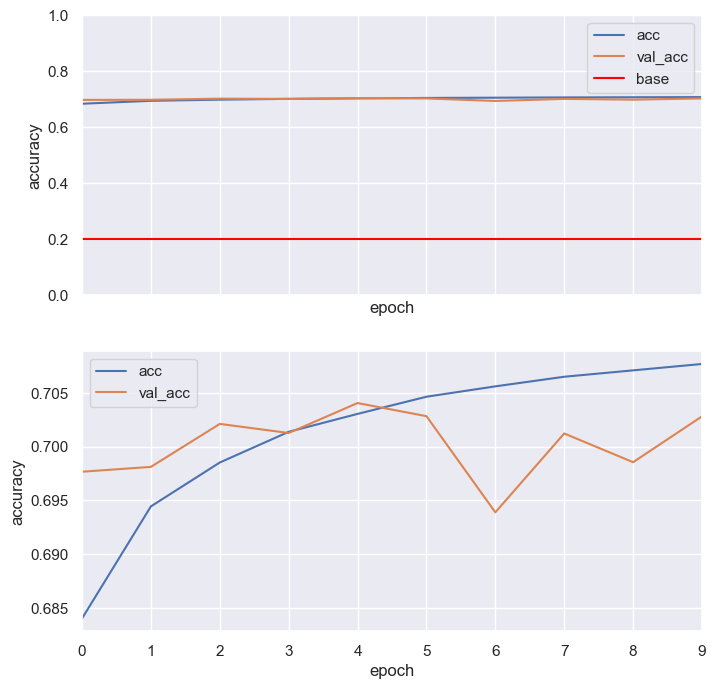

In [31]:
hist = history.history
acc, val_acc = hist["accuracy"], hist["val_accuracy"]

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 8), dpi=100)

for i, ax in enumerate(axes):
    ax.plot(acc, label="acc")
    ax.plot(val_acc, label="val_acc")
    
    ax.set_xlim(0, epochs - 1)
    if i == 0:
        ax.set_ylim(0.0, 1.0)
        ax.axhline(0.2, color="red", label="base")
        
    ax.grid(visible=True, axis="both")
    ax.legend()
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")

plt.show()

##### Evaluate

In [32]:
# Get probabilities per class
y_pred = model.predict(X_test)

21845/21845 [==============================] - 34s 2ms/step


In [33]:
# Get star predictions and negative/positive predictions
y_pred_multi = tf.argmax(y_pred, axis=1)

In [48]:
# Calculate continuous star rating based on probabilities
star_reg = tf.reduce_sum(y_pred * np.array([0, 1, 2, 3, 4]), axis=1)
star_reg

<tf.Tensor: shape=(699028,), dtype=float64, numpy=
array([3.93242944, 3.58393372, 0.07657244, ..., 3.97714437, 3.13312901,
       3.92242546])>

In [52]:
# Determine if sentiment is negative or postiive
y_pred_binary = star_reg > 2

In [53]:
print("multi-class accuracy: " + str((y_pred_multi == y_test).numpy().sum() / len(y_test)))
print("(compare to ~0.2)")

multi-class accuracy: 0.702825923997322
(compare to ~0.2)


In [54]:
print("binary accuracy: " + str((y_pred_binary == (y_test >= 3)).numpy().sum() / len(y_test)))
print("(compare to ~0.5)")

binary accuracy: 0.9094485485559949
(compare to ~0.5)


In [36]:
avg_err = tf.reduce_sum(tf.math.abs(y_test - y_pred_multi)) / len(y_test)
avg_err = avg_err.numpy()
print(f"Average of {avg_err:.4f} stars off")

Average of 0.3575 stars off


##### Visualize Attention

In [37]:
# Get attention scores
_, attns = model(X_test[:100], return_att=True)

# Get attention for each sample
attns = tf.reduce_mean(attns, axis=2)[:, 0, :]
attns

<tf.Tensor: shape=(100, 200), dtype=float32, numpy=
array([[0.08779085, 0.03332892, 0.07753161, ..., 0.        , 0.        ,
        0.        ],
       [0.12678571, 0.07251964, 0.11298013, ..., 0.        , 0.        ,
        0.        ],
       [0.02735073, 0.19512478, 0.02457746, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.11718269, 0.04146399, 0.02325249, ..., 0.        , 0.        ,
        0.        ],
       [0.06970514, 0.05388234, 0.03915521, ..., 0.        , 0.        ,
        0.        ],
       [0.14236137, 0.04052756, 0.02136128, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)>

In [38]:
attns[0][:34]

<tf.Tensor: shape=(34,), dtype=float32, numpy=
array([0.08779085, 0.03332892, 0.07753161, 0.05617767, 0.01231178,
       0.04047775, 0.05520739, 0.00888121, 0.03887216, 0.03380498,
       0.01446113, 0.0240939 , 0.06144869, 0.0187546 , 0.02441565,
       0.0239276 , 0.01999373, 0.01230694, 0.01127734, 0.02241655,
       0.00765679, 0.00569799, 0.0148555 , 0.01498795, 0.01504076,
       0.02895071, 0.01511669, 0.00749619, 0.00850148, 0.0160686 ,
       0.01307386, 0.00459279, 0.01539802, 0.0102742 ], dtype=float32)>

<Original Text>
Absolutely love this pop up beer garden. Lots of shaded areas, seating and dog friendly. Besides beer they serve some really yummy margaritas and mixed drinks. They're next to Jamaican jerk hut so you can get food from there or the back bar. Brought my dogs here a few times and it was great.

<Preprocessed>
['absolutely', 'love', 'pop', 'beer', 'garden', 'lots', 'shaded', 'areas', 'seating', 'dog', 'friendly', 'beer', 'serve', 'yummy', 'margaritas', 'mixed', 'drinks', "'", 'jamaican', 'jerk', 'hut', 'food', 'bar', 'brought', 'dogs', 'times', 'great']


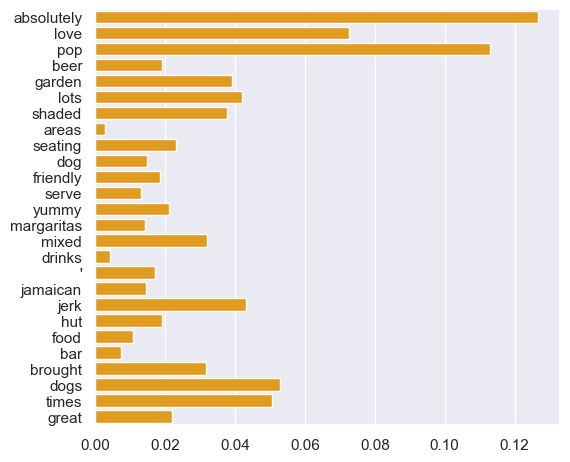

In [64]:
sample_idx = 1

# Get word sequences without oov words
in_seq = X_test_norm[sample_idx]
in_seq = [tok for tok in prep.tokenizer.sequences_to_texts(prep.tokenizer.texts_to_sequences(in_seq)) if tok]
seq_len = len(in_seq)

# Get attention values
attn_vals = attns[sample_idx][:seq_len].numpy()

print("<Original Text>")
print(test["text"].iloc[sample_idx])

print("\n<Preprocessed>")
print(in_seq)

plt.figure(figsize=(6, 0.2 * seq_len), dpi=100)
sns.barplot(y=in_seq, x=attn_vals, ci=None, color="orange")

plt.show()